In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = '/content/Fig1016(a)(building_original).tif'
image = cv2.imread(image_path)

# Check if the image was successfully loaded
if image is None:
    print(f"Error: Unable to load image at {image_path}")
    exit()

In [11]:
kernel_size = 7
sigma = 1.5
high_thresh = 150
low_thresh = 40

In [12]:
# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian Blur
blurred = cv2.GaussianBlur(gray, (kernel_size, kernel_size), sigma)

In [13]:
# Compute Sobel gradients
grad_x = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
grad_y = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)

magnitude = cv2.magnitude(grad_x, grad_y)
angle = np.arctan2(grad_y, grad_x)
magnitude = cv2.convertScaleAbs(magnitude)

In [15]:
def apply_non_max_suppression(mag, ang):
    height, width = mag.shape
    output = np.zeros_like(mag)
    angle = np.rad2deg(ang + np.pi) % 180

    direction_set = [(0, 1), (-1, 1), (-1, 0), (-1, -1)]

    for i in range(1, height - 1):
        for j in range(1, width - 1):
            dir_idx = int(((angle[i, j] + 22.5) % 180) // 45)
            dx, dy = direction_set[dir_idx]
            front = mag[i + dx, j + dy]
            back = mag[i - dx, j - dy]

            if mag[i, j] >= front and mag[i, j] >= back:
                output[i, j] = mag[i, j]

    return output

In [16]:
thin_edges = apply_non_max_suppression(magnitude, angle)

In [17]:
def perform_hysteresis(edge_map, low_t, high_t):
    strong = (edge_map >= high_t)
    weak = (edge_map >= low_t) & ~strong

    result = np.zeros_like(edge_map, dtype=np.uint8)
    result[strong] = 255

    connect_dirs = [(-1, 0), (1, 0), (0, -1), (0, 1),
                    (-1, -1), (-1, 1), (1, -1), (1, 1)]

    for i in range(1, edge_map.shape[0] - 1):
        for j in range(1, edge_map.shape[1] - 1):
            if strong[i, j]:
                for dx, dy in connect_dirs:
                    ni, nj = i + dx, j + dy
                    if weak[ni, nj]:
                        result[ni, nj] = 255

    return result, strong.astype(np.uint8)*255, weak.astype(np.uint8)*255

In [19]:
final_edges, strong_edges, weak_edges = perform_hysteresis(thin_edges, low_thresh, high_thresh)

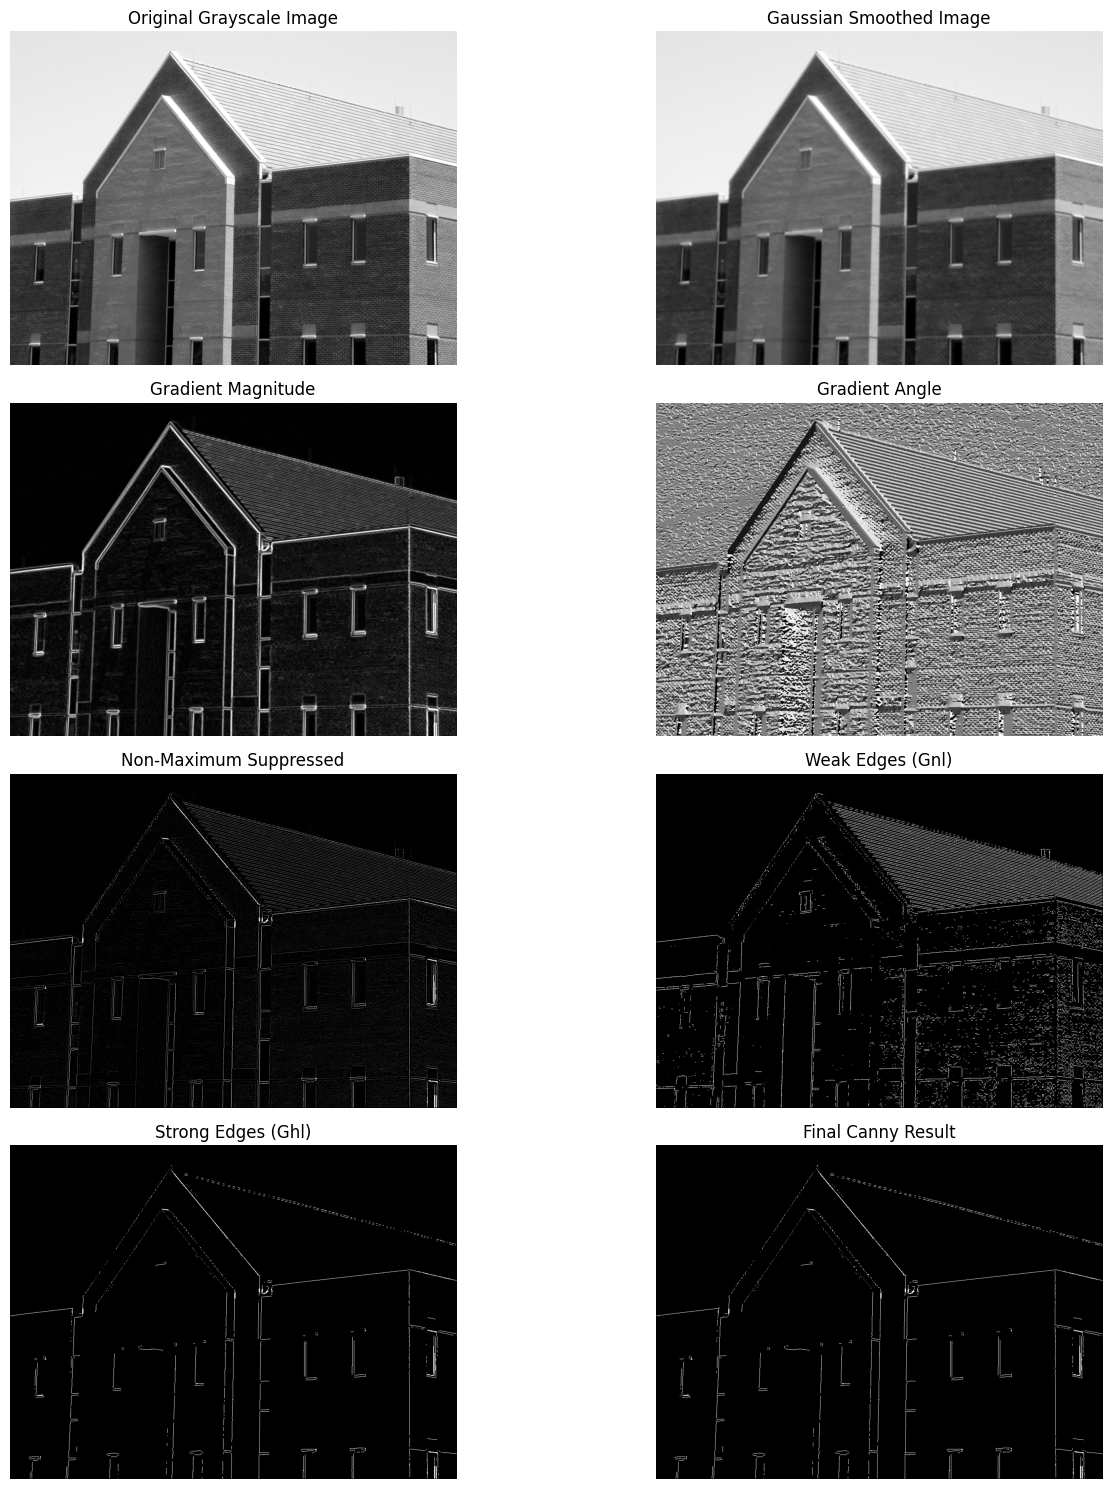

In [20]:
plt.figure(figsize=(15, 15))

rows, cols = 4, 2

plt.subplot(rows, cols, 1)
plt.imshow(gray, cmap='gray')
plt.title('Original Grayscale Image')
plt.axis('off')

plt.subplot(rows, cols, 2)
plt.imshow(blurred, cmap='gray')
plt.title('Gaussian Smoothed Image')
plt.axis('off')

plt.subplot(rows, cols, 3)
plt.imshow(magnitude, cmap='gray')
plt.title('Gradient Magnitude')
plt.axis('off')

plt.subplot(rows, cols, 4)
plt.imshow(angle, cmap='gray')
plt.title('Gradient Angle')
plt.axis('off')

plt.subplot(rows, cols, 5)
plt.imshow(thin_edges, cmap='gray')
plt.title('Non-Maximum Suppressed')
plt.axis('off')

plt.subplot(rows, cols, 6)
plt.imshow(weak_edges, cmap='gray')
plt.title('Weak Edges (Gnl)')
plt.axis('off')

plt.subplot(rows, cols, 7)
plt.imshow(strong_edges, cmap='gray')
plt.title('Strong Edges (Ghl)')
plt.axis('off')

plt.subplot(rows, cols, 8)
plt.imshow(final_edges, cmap='gray')
plt.title('Final Canny Result')
plt.axis('off')

plt.tight_layout()
plt.show()